In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import warnings

%matplotlib inline

Создадим датасет

In [2]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=6, random_state=42)

In [3]:
X.shape

(1000, 10)

In [4]:
y.shape

(1000,)

Модель - DecisionTreeRegressor

In [5]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака для сравнения с ророгом в узле
        self.t = t  # порог
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch

class Leaf:

    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = self.predict()

    def predict(self):
        #  найдем значение как среднее по выборке
        prediction = np.mean(self.values)
        return prediction
    
class RegressionTree():

    def __init__(self, max_depth = 50):
        self.max_depth = max_depth
        self.tree = None

    # Определим критерий информативности
    # В случае регрессии разброс значений будет характеризоваться дисперсией
    def inf_criterion(self, values):
        return np.var(values)

    # Функция рассчета качества
    def quality(self, left_labels, right_labels, current_dispersion):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_dispersion - p * self.inf_criterion(left_labels) - (1 - p) * self.inf_criterion(right_labels)

    # Функция разбиение данных в узле
    def split(self, data, values, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_values = values[left]
        false_values = values[right]

        return true_data, false_data, true_values, false_values

    # Функция нахождения наилучшего разбиения
    def find_best_split(self, data, values):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 5
        current_inf = self.inf_criterion(values)
        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # проверяем только уникальные значения признака
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, values, index, t)
                #  Если в узле остается < 5 объекто - пропускаем узел
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_inf)

                #  выбираем порог с максимальным приростом качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    # Функция построения дерева
    def build_tree(self, data, values, current_deep, max_depth):

        quality, t, index = self.find_best_split(data, values)

        #  Первый базовый случай (прекращаем рекурсию, если нет прироста качества)
        if quality == 0:
            return Leaf(data, values)
        # Второй базовый случай (прекращаем рекурсию, если превышена глубина дерева)
        # (критерий считается достаточно грубым, но хорошо зарекомендовал себя в композициях деревьев)
        if current_deep > max_depth:
            return Leaf(data, values)

        current_deep += 1

        true_data, false_data, true_values, false_values = self.split(data, values, index, t)
        # Рекурсивно строим деревья
        true_branch = self.build_tree(true_data, true_values, current_deep, max_depth)
        false_branch = self.build_tree(false_data, false_values, current_deep, max_depth)

        # Возвращаем класс узла всего дерева
        return Node(index, t, true_branch, false_branch)

    # Предскажем объект
    def predict_value(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_value(obj, node.true_branch)
        else:
            return self.predict_value(obj, node.false_branch)

    def predict(self, data):

        pred_values = []
        for obj in data:
            prediction = self.predict_value(obj, self.tree)
            pred_values.append(prediction)
        return pred_values

    def fit(self, data, values):
        self.tree = self.build_tree(data, values, 0, self.max_depth)

GBoost_DecisionTreeRegressor

In [6]:
class GradBoost:

    def __init__(self, algoritm, max_depth, n_trees, alpha, coef):
        self.max_depth = max_depth
        self.n_trees = n_trees
        self.alpha = alpha
        self.coef = coef
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        self.algoritm = algoritm
    
    # L2 loss
    def bias(self, y, z):
        return 2*(y - z)
    @staticmethod
    def mean_squared_error(y_real, prediction):
        return ((sum((y_real - prediction)**2)) / len(y_real))

    def fit(self, X_train,X_test, Y_train, Y_test):
        # Cписок деревьев
        trees = []

        for i in range(self.n_trees):
            tree = self.algoritm(max_depth=self.max_depth)
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(trees) == 0:
                tree.fit(X_train, Y_train)
                
                self.train_errors.append(mean_squared_error(Y_train, self.predict(X_train)))
                self.test_errors.append(mean_squared_error(Y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                values = self.predict(X_train)
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(Y_train, values))
                
                self.train_errors.append(mean_squared_error(Y_train, self.predict(X_train)))
                self.test_errors.append(mean_squared_error(Y_test, self.predict(X_test)))
                
            self.trees.append(tree)
        return self.trees, self.train_errors, self.test_errors

    def predict(self, X):
        return np.array([sum([self.alpha * coef * alg.predict([x])[0] for alg,\
                        coef in zip(self.trees, self.coef)]) for x in X])

PCA

In [7]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components

    def fit_transform(self, data):
        data_ = data.astype(float)
        cov_matrix = data_.T.dot(data_) # Матрица ковариаций
        eig_values, eig_vectors = np.linalg.eig(cov_matrix) # Собственные значения, собственные вектора
        eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))] # список кортежей (значение, вектор)
        eig_pairs.sort(key=lambda x: x[0], reverse=True) # сортируем список по убыванию eig_values

        eig_sum = sum(eig_values)
        var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
        cum_var_exp = np.cumsum(var_exp)

        w = np.hstack(([eig_pairs[i][1].reshape(data.shape[1], 1) for i in range(self.n_components)]))
        data_pca = data_.dot(w)
        return data_pca, print(f'Доля дисперсии, описываемая каждой компонентой \n{var_exp}'),\
    print(f'Кумулятивная доля дисперсии \n{cum_var_exp}')

Стандартизация

In [8]:
def normalin(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j] = (data[i][j] - means[j])/stds[j]
    return data

train_test_split

In [9]:
def tts(X, y, test_size, random_state):
    np.random.seed(random_state)
    
    train_test_cut = int(len(X) * (1 - test_size))
    
    shuffle_index = np.random.permutation(X.shape[0])
    X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]
    
    X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
    return X_train, X_test, y_train, y_test

Метрики

In [10]:
def r2_score(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total

# Эта функция внедрена в класс как статический метод
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [11]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, model):
    train_prediction = model.predict(X_train)

    print(f'Ошибка алгоритма из {n_trees} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = model.predict(X_test)

    print(f'Ошибка алгоритма из {n_trees} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

### Нормализуем признаки

In [12]:
# В датасете они и так приведены к единому стандарту
#X = normalin(X)

### TTS

In [13]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3, random_state=21)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 10), (300, 10), (700,), (300,))

### Построим модель без использования главных компонент

In [15]:
n_trees = 10
coefs = [1] * n_trees

In [16]:
model = GradBoost(algoritm=RegressionTree, max_depth=8, n_trees=n_trees, alpha=0.1, coef = coefs)

In [17]:
trees, train_errors, test_errors = model.fit(X_train,X_test,y_train, y_test)

In [18]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, model)

Ошибка алгоритма из 10 на тренировочной выборке: 172.9989867166722
Ошибка алгоритма из 10 на тестовой выборке: 486.6491484454596


In [19]:
y_train_pred = model.predict(X_train)

In [20]:
r2_score(y_train_pred, y_train)

0.963036168749641

In [21]:
y_test_pred = model.predict(X_test)

In [22]:
r2_score(y_test_pred, y_test)

0.9005779042568214

### Выведем главные компоненты и сравним результат

In [23]:
pca = PCA(n_components = 8)
components = pca.fit_transform(X)

Доля дисперсии, описываемая каждой компонентой 
[11.627001342569688, 11.067155381407176, 10.56320723502046, 10.362066989438974, 10.280327621788981, 9.962962894202814, 9.651309159916512, 9.476324611912798, 8.657770749213215, 8.351874014529393]
Кумулятивная доля дисперсии 
[ 11.62700134  22.69415672  33.25736396  43.61943095  53.89975857
  63.86272146  73.51403062  82.99035524  91.64812599 100.        ]


Довольно много теряем, ибо сет так устроен. 

Попробуем на 83%, тоесть понизим пространство до 8 признаков

In [24]:
pca_components = components[0][:]
pca_components

array([[-0.07342326, -0.9095709 , -0.62549641, ..., -0.06514534,
         0.74226336,  0.00279143],
       [-0.32316428, -1.71697458,  1.70080402, ..., -2.32672045,
        -2.51892844, -0.20971608],
       [-0.00317663,  1.27323693,  0.88152529, ..., -0.48989518,
        -0.90105594, -0.94441625],
       ...,
       [-2.39060937, -0.17992891, -0.61642291, ..., -0.54406748,
         0.99159429, -0.74152271],
       [-1.40090991,  1.40741158, -0.30145907, ...,  1.0325543 ,
         0.5216645 , -1.32906562],
       [ 1.97405618, -0.45123336, -0.64765529, ...,  0.1626634 ,
         1.6016728 , -0.62847938]])

In [25]:
X_train, X_test, y_train, y_test = tts(pca_components,y, test_size=0.3, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 8), (300, 8), (700,), (300,))

In [26]:
model_2 = GradBoost(algoritm=RegressionTree, max_depth=8, n_trees=n_trees, alpha=0.1, coef = coefs)
trees_pca, train_errors_pca, test_errors_pca = model_2.fit(X_train, X_test, y_train, y_test)

In [27]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, model_2)

Ошибка алгоритма из 10 на тренировочной выборке: 452.2235430285971
Ошибка алгоритма из 10 на тестовой выборке: 1418.7900555467875


In [28]:
y_train_pred = model_2.predict(X_train)
r2_score(y_train_pred, y_train)

0.9033756494809713

In [29]:
y_test_pred = model_2.predict(X_test)
r2_score(y_test_pred, y_test)

0.7101421399942067

#### Ожидаемо, мы потеряли в точности. Но этот готовый датасет так устроен. Как вариант, можно не заменять исходный датасет, а добавить к примеру первые 2 компоненты к нему и посмотреть на результат

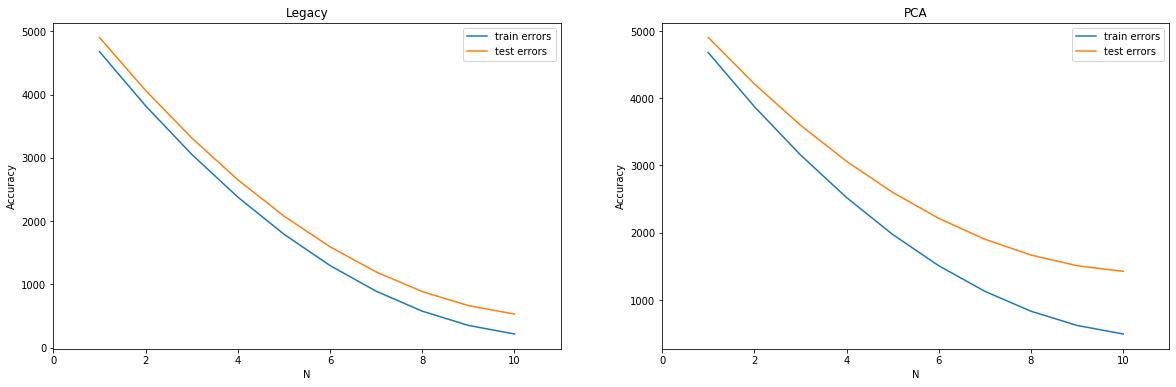

In [30]:
x = list(range(1, 11))

plt.figure(figsize = (20, 6))

plt.subplot(1,2,1)
plt.xlim(0, 11)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.title('Legacy')
plt.legend(loc='upper right')


plt.subplot(1,2,2)
plt.xlim(0, 11)
plt.plot(x, train_errors_pca, label='train errors')
plt.plot(x, test_errors_pca, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.title('PCA')
plt.legend(loc='upper right')

plt.show()